In [7]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

img2 = cv.imread('Sample VIIRS/jan721.tiff')
# img2 = cv.imread('Sample VIIRS/jan921.tiff')

M = 512
N = M
i = 0

if os.path.exists("prediction_inputs"):
    os.system("rm -r prediction_inputs/")
os.mkdir("prediction_inputs")
os.mkdir("prediction_inputs/cloudy_image")


In [8]:
arr = []
print(img2.shape)

# slicing images into 512 x 512, with iteration moving at 512/4
for x in range(0,img2.shape[1],M//4):
    for y in range(0,img2.shape[0],N//4):
        # getting the image slice
        sampimg = img2[x:x+M,y:y+N]
        # checking if image is 512x512
        if sampimg.shape == (512, 512, 3):
            # store image name, current position
            arr.append([str(i)+".tiff", x, x+M, y, y+N])
            # writing it into the prediction directory
            cv.imwrite(os.path.join("prediction_inputs/cloudy_image", arr[i][0]), sampimg)
            i += 1

(601, 813, 3)


In [9]:
"""
Python prediction script. Use based on whether you have a GPU or not
"""

# w/o GPU
!python predict_general.py --test_dir prediction_inputs/ --config pretrained_models/Denoised/config_cpu.yml --pretrained pretrained_models/Denoised/gen_model_epoch_60.pth 

# w/ GPU
# !python predict_general.py --config pretrained_models/Denoised/config_gpu.yml --pretrained pretrained_models/Denoised/gen_model_epoch_60.pth  --cuda

Random Seed:  0
===> Loading models
  0%|                                                     | 0/3 [00:00<?, ?it/s]0.tiff
2.tiff
1.tiff
100%|█████████████████████████████████████████████| 3/3 [01:02<00:00, 20.91s/it]


In [14]:
# base arrays for reconstructing image
new_img = np.zeros(img2.shape)
attentionmap = np.zeros(img2.shape)

# getting the 2nd part of the three images
# recall: 1st image - cloudy, 2nd image - cleaned, 3rd image - attention map
for item in arr:
    val = cv.imread(os.path.join("prediction_inputs/epoch_0001", item[0]))
    h, w, channels = val.shape
    trio = w//3
    cleaned = val[:, 1*trio:2*trio] 
    # adding the image based on its stored position
    new_img[item[1]:item[2], item[3]:item[4]] = cleaned
    attentionmap[item[1]:item[2], item[3]:item[4]] = val[:, 2*trio:]

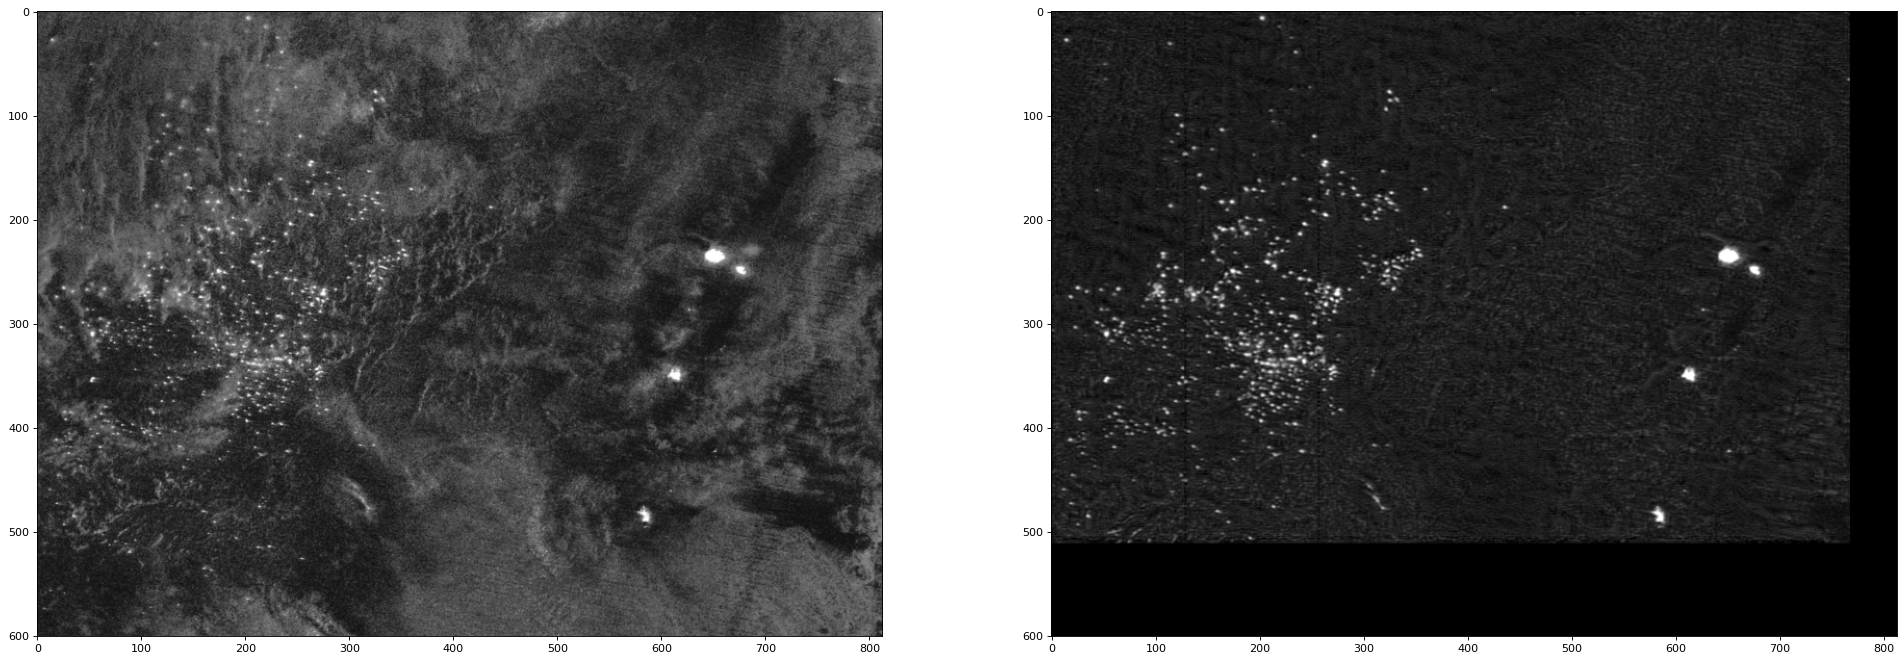

In [15]:
fig = plt.figure(figsize=(30, 30),dpi=80) 
plt.subplot(121), plt.imshow(img2) # original image
plt.subplot(122); plt.imshow(new_img.astype("uint8")) # cleaned/newly reconstructed image

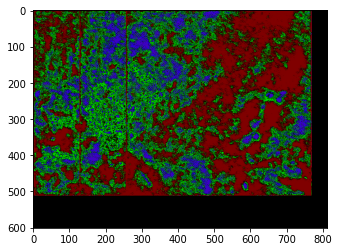

In [16]:
plt.imshow(attentionmap.astype("uint8"))

In [13]:
# cv.imwrite("../prediction_inputs/cleanedimg.png", new_img.astype("uint8"))